## 

In [1]:
import pandas as pd
import re

quora_question_data = pd.read_csv('Dataset/train.csv')
quora_question_data['is_duplicate'] = quora_question_data['is_duplicate'].astype(int)
question = pd.concat([ quora_question_data.loc[:, ['qid1', 'question1']].rename(columns={'qid1': 'qid', 'question1': 'question'}), 
                      quora_question_data.loc[:, ['qid2', 'question2']].rename(columns={'qid2': 'qid', 'question2': 'question'}) ], axis=0)

question['question'] = question['question'].astype(str)
question['qid'] = question['qid'].astype(int)
question = question.sort_values(by='qid')
question = question.drop_duplicates(subset='qid', keep='first')
question = question.reset_index()
question = question.drop('index', axis=1)

def process_text(text): 
    # convert the text to lower case, and substitute space for any special characters
    return re.sub(r'[^a-zA-Z0-9\s]', ' ', text.lower())

question['question'] = question['question'].apply(process_text)
question['question'] = question['question'].astype(str)
question.sample(1)

,qid,question
78621,78622,what kind of job can a 16 year old get at an a...


### Model

In [3]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

documents = list(question['question'])


encoded_inputs = tokenizer(
    documents,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

device = "cuda:4" if torch.cuda.is_available() else "cpu"
model = model.to(device)


batch_size = 32
encoded_inputs = encoded_inputs.to(device)

def process_in_batches(documents, batch_size, model, tokenizer, device):
    embeddings = []
    model.eval()  
    for i in range(0, len(documents), batch_size):
        batch = documents[i:i + batch_size]

        encoded_inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            return_tensors="pt"
        )

        encoded_inputs = {key: val.to(device) for key, val in encoded_inputs.items()}

        with torch.no_grad():
            outputs = model(**encoded_inputs)
        
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings)

    return torch.cat(embeddings, dim=0)

document_embeddings = process_in_batches(documents, batch_size, model, tokenizer, device)
print("Document embeddings shape:", document_embeddings.shape)

Document embeddings shape: torch.Size([537933, 768])


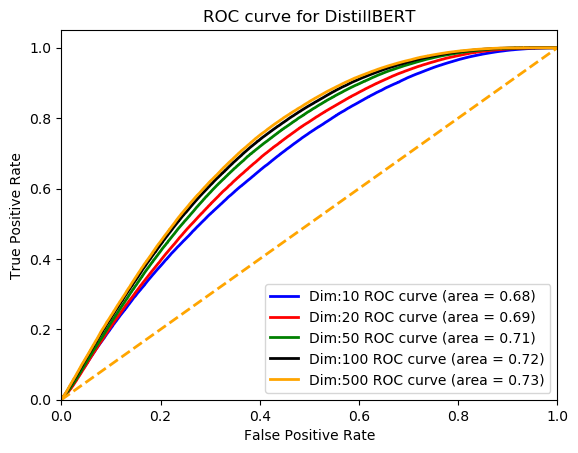

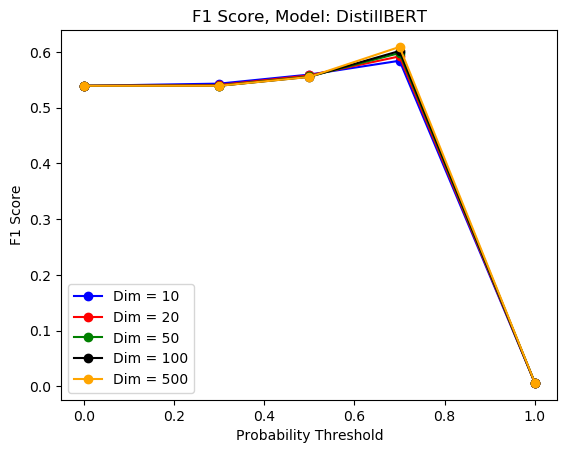

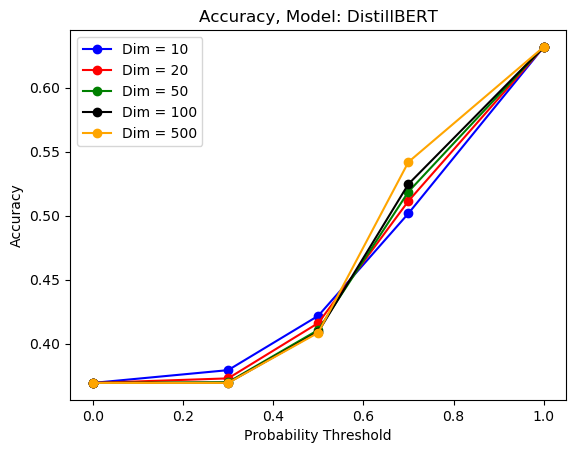

In [5]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import roc_curve, auc 
import matplotlib.pyplot as plt
from collections import defaultdict

document_embeddings_np = document_embeddings.cpu().numpy()

embedding_dims = [10, 20, 50, 100, 500]
colors = ['b', 'r', 'g', 'black', 'orange']


def update_metrics(prob, is_true, prob_thresholds, metrics):
    for threshold, metric in zip(prob_thresholds, metrics):
        if prob >= threshold:
            if is_true:
                metric['tp'] += 1
            else:
                metric['fp'] += 1
        else:
            if is_true:
                metric['fn'] += 1 
            else:
                metric['tn'] += 1


f1_scores_all = []
accuracies_all = []    
fpr_all = []
tpr_all = []
for i, dim in enumerate(embedding_dims):
    pca = PCA(n_components=dim)
    reduced_embeddings = pca.fit_transform(document_embeddings_np)
    y_true = []
    y_scores = []
    
    prob_thresholds = [0.0, 0.3, 0.5, 0.7, 1.0]
    metrics = [defaultdict(int) for _ in range(len(prob_thresholds))]

    for index, row in quora_question_data.iterrows():
        # using cosine similary
        qid1 = row['qid1'] - 1
        qid2 = row['qid2'] - 1
        
        embeeding_q1 = reduced_embeddings[qid1]
        embedding_q2 = reduced_embeddings[qid2]
        
        dot_product = np.dot(embeeding_q1, embedding_q2)
        norm_eq1 = np.linalg.norm(embeeding_q1)
        norm_eq2 = np.linalg.norm(embedding_q2)
        cosine_similarity = dot_product / (norm_eq1 * norm_eq2)

        prob = (cosine_similarity + 1) / 2
        
        y_true.append(row['is_duplicate']) 
        y_scores.append(prob)
        update_metrics(y_scores[-1], y_true[-1], prob_thresholds, metrics)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fpr_all.append(fpr)
    tpr_all.append(tpr)
    
    f1_scores = []
    accuracies = []
    for threshold, metric in zip(prob_thresholds, metrics):
        precision = metric['tp'] / (metric['tp'] + metric['fp'])
        recall = metric['tp'] / (metric['tp'] + metric['fn'])
        accuracy = (metric['tp'] + metric['tn']) / (metric['tp'] + metric['tn'] + metric['fp'] + metric['fn'])
        f1_score = 2 * recall * precision / (precision + recall)
            
        f1_scores.append(f1_score)
        accuracies.append(accuracy)
    
    f1_scores_all.append(f1_scores)
    accuracies_all.append(accuracies)

plt.figure()
for i, (fpr, tpr) in enumerate(zip(fpr_all, tpr_all)):
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label='Dim:' + str(embedding_dims[i]) + ' ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color=colors[i], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for DistillBERT')
plt.legend(loc="lower right")
plt.show()

plt.figure()
for i, f1_scores in enumerate(f1_scores_all):
    plt.plot(prob_thresholds, f1_scores, marker='o', color=colors[i], label=f"Dim = {embedding_dims[i]}")
plt.xlabel("Probability Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score, Model: DistillBERT")
plt.legend()
plt.show()

plt.figure()
for i, accuracies in enumerate(accuracies_all):
    plt.plot(prob_thresholds, accuracies, marker='o', color=colors[i], label=f"Dim = {embedding_dims[i]}")
plt.xlabel("Probability Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy, Model: DistillBERT")
plt.legend()
plt.show()

In [7]:
for i, dim in enumerate(embedding_dims):
    for p, f1 in zip(prob_thresholds, f1_scores_all[i]):
        print(f"TF-IDF, dim = {dim}, prob_threshold = {p}, f1_score = {f1}")


for i, dim in enumerate(embedding_dims):
    for p, a in zip(prob_thresholds, accuracies_all[i]):
        print(f"TF-IDF, dim = {dim}, prob_threshold = {p}, accuracy = {a}")
    
    

TF-IDF, dim = 10, prob_threshold = 0.0, f1_score = 0.5392907273558268
TF-IDF, dim = 10, prob_threshold = 0.3, f1_score = 0.5431784634593368
TF-IDF, dim = 10, prob_threshold = 0.5, f1_score = 0.5594357630219767
TF-IDF, dim = 10, prob_threshold = 0.7, f1_score = 0.5842609905191165
TF-IDF, dim = 10, prob_threshold = 1.0, f1_score = 0.00598214702995747
TF-IDF, dim = 20, prob_threshold = 0.0, f1_score = 0.5392907273558268
TF-IDF, dim = 20, prob_threshold = 0.3, f1_score = 0.540691703721145
TF-IDF, dim = 20, prob_threshold = 0.5, f1_score = 0.5579568368491311
TF-IDF, dim = 20, prob_threshold = 0.7, f1_score = 0.5920789625836294
TF-IDF, dim = 20, prob_threshold = 1.0, f1_score = 0.005942246703388417
TF-IDF, dim = 50, prob_threshold = 0.0, f1_score = 0.5392907273558268
TF-IDF, dim = 50, prob_threshold = 0.3, f1_score = 0.5395090443479377
TF-IDF, dim = 50, prob_threshold = 0.5, f1_score = 0.5560019229407578
TF-IDF, dim = 50, prob_threshold = 0.7, f1_score = 0.5981029323387461
TF-IDF, dim = 50, 